### Import packages

In [247]:
#@title Imports
import os
import sys
import json
import copy
import random
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from keras.utils import np_utils

#!pip install torch==1.8.1
import torch
torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as nnf
softplus = torch.nn.Softplus()
import torch.optim as torchopt

#!pip install pyro-ppl==1.3.0
import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as pyroopt
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.distributions import Normal, Categorical, OneHotCategorical

import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [225]:
# set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [226]:
print(torch.version.cuda)

11.6


In [227]:
#device ="cpu"

In [228]:
dataset = pd.read_csv('smart_grid_stability_augmented.csv')
dataset.replace({'stabf': {'unstable':0, 'stable':1}}, inplace=True)
dataset.drop(columns=['stab'])


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,1
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,1
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0


In [248]:
x = dataset.iloc[:, :12]
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(x)
#x = (x-x.min())/(x.max()-x.min())
y = dataset['stabf']
x = x.to_numpy()
y = y.to_numpy()
X_test= x[len(x)-1000:len(x)]
t_test=y[len(x)-1000:len(x)]

X_val= x[len(x)-2000:len(x)-1000]
y_val=y[len(x)-2000:len(x)-1000]

In [249]:
x_train=torch.tensor(x[0:1000], dtype=torch.float).to(device)
y_train = torch.tensor(y[0:1000],dtype=torch.float ).to(device)

x_test=torch.tensor(X_test, dtype=torch.float).to(device)
y_test=torch.tensor(t_test, dtype=torch.float).to(device)

x_val=torch.tensor(X_val, dtype=torch.float).to(device)
y_val=torch.tensor(t_val, dtype=torch.float).to(device)

In [250]:
batch_size=1

### Deterministic Neural Network


In [136]:
class DeterministicNetwork(nn.Module):
  
    def __init__(self):

        # initialize nn.Module
        super(DeterministicNetwork, self).__init__()

    
        # architecture
        self.model = nn.Sequential(
                    nn.Linear(12, 100),
                    nn.ReLU(),
                    nn.Linear(100, 2))
    
        self.name = "deterministic_network"
      

    def forward(self, inputs, *args, **kwargs):
        """ Compute predictions on `inputs`. """
        return self.model(inputs)

    def train(self, x_train, y_train, lr, epochs, device):
        """ Train network. """
        random.seed(0)

        # DataLoader combines a dataset and a sampler, and provides an 
        # iterable over the given dataset
        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)

        # send network to device
        self.to(device)

        # set optimizer and loss function for training
        optimizer = torchopt.Adam(params=self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
      
        
        for epoch in range(epochs):
            total_loss = 0

            for x_batch, y_batch in train_loader:

                # send data to device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                

                ### loss optimization ###
                outputs = self.forward(x_batch) # forward pass
              

                # reset gradients w.r.t. network parameters
                optimizer.zero_grad() 

                # loss on predicted labels vs true labels
                loss = loss_fn(outputs, y_batch.long()) 
                

                # backward pass: computes the derivative of the loss w.r.t.
                # the parameters using backpropagation.
                loss.backward() 

                # update parameters, i.e. take a step based on the gradients 
                # of the parameters.
                optimizer.step() 
                #########################

                # update training loss
                total_loss += loss.data.item() / len(train_loader.dataset)
        
            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.8f}", end="\t")

    def save(self, savedir):
        """ Save network weights. """
        self.to("cpu") # send network to cpu
        os.makedirs(savedir, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(savedir, self.name+"_weights.pt"))
      
    def load(self, savedir, device):
        """ Load network weights. """
        self.load_state_dict(torch.load(os.path.join(savedir, self.name+"_weights.pt")))
        self.to(device)
      
    def evaluate(self, x_test, y_test, device, *args, **kwargs):
        """ Evaluate network on test set. """
        random.seed(0)
        self.to(device)

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), batch_size=batch_size, shuffle=False)       

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                outputs = self(x_batch) # self.forward(x_batch)
                predictions = outputs.argmax(dim=-1)
                correct_predictions += (predictions == y_batch).sum()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)

        return accuracy

In [22]:
det_model = DeterministicNetwork()
det_model.train(x_train=x_train, y_train=y_train, lr=0.005, epochs=20, device=device)

accuracy = det_model.evaluate(x_test, y_test, device=device)
print("\nTest accuracy: %.2f%%" % (accuracy))


[Epoch 1]	 loss: 0.44752975	
[Epoch 2]	 loss: 0.33713030	
[Epoch 3]	 loss: 0.29971516	
[Epoch 4]	 loss: 0.27157110	
[Epoch 5]	 loss: 0.25837142	
[Epoch 6]	 loss: 0.24886444	
[Epoch 7]	 loss: 0.23979088	
[Epoch 8]	 loss: 0.23549043	
[Epoch 9]	 loss: 0.22673692	
[Epoch 10]	 loss: 0.22281379	
[Epoch 11]	 loss: 0.21734950	
[Epoch 12]	 loss: 0.21392382	
[Epoch 13]	 loss: 0.21080420	
[Epoch 14]	 loss: 0.20982074	
[Epoch 15]	 loss: 0.20888003	
[Epoch 16]	 loss: 0.20359082	
[Epoch 17]	 loss: 0.20539323	
[Epoch 18]	 loss: 0.20149298	
[Epoch 19]	 loss: 0.20354254	
[Epoch 20]	 loss: 0.20234155	
Test accuracy: 49.80%


### Bayesian Neural Network

In [252]:
class BayesianNetwork(PyroModule):

    def __init__(self):
        # initialize PyroModule
        super(BayesianNetwork, self).__init__()

        # BayesianNetwork extends PyroModule class
        self.det_network = DeterministicNetwork()

        self.name = "bayesian_network"
        self.Train_loss =torch.tensor([])
        self.Val_loss =torch.tensor([])
        self.Train_acc =torch.tensor([])
        self.Val_acc =torch.tensor([])
      
    def model(self, x_data, y_data):
        """ Sets prior distributions and conditions on the observations. """
        priors = {}
    
        # set Gaussian priors on the weights of self.det_network
        for key, value in self.det_network.state_dict().items():
            loc = torch.zeros_like(value)
            scale = torch.ones_like(value)
            prior = Normal(loc=loc, scale=scale)
            priors.update({str(key):prior})

        # pyro.random_module places `priors` over the parameters of the nn.Module 
        # self.det_network and returns a distribution, which upon calling 
        # samples a new nn.Module (`lifted_module`)
        lifted_module = pyro.random_module("module", self.det_network, priors)()

        # samples are conditionally independent w.r.t. the observed data
        with pyro.plate("data", len(x_data)):
            out = lifted_module(x_data) # out.shape = (batch_size, num_classes)
            obs = pyro.sample("obs", Categorical(logits=out), obs=y_data) # obs.shape = (batch_size)

    def guide(self, x_data, y_data=None):
        """ Samples from the Variational distribution and returns predictions. """

        # take random samples of det_network's weights from the chosen variational family
        dists = {}
        for key, value in self.det_network.state_dict().items():

            # torch.randn_like(x) builds a random tensor whose shape equals x.shape
            loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value)) 
            scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))

            # softplus is a smooth approximation to the ReLU function
            # which constraints the scale tensor to positive values
            distr = Normal(loc=loc, scale=softplus(scale))

            # add key-value pair to the samples dictionary
            dists.update({str(key):distr})

        # define a random module from the dictionary of distributions
        lifted_module = pyro.random_module("module", self.det_network, dists)()

        with pyro.plate("data", len(x_data)):

            # compute predictions on `x_data`
            out = lifted_module(x_data)
            preds = nnf.softmax(out, dim=-1)
            return preds
        
    def forward(self, inputs, n_samples=10, sample_idx=None, avg_prediction=True):
        """ Compute predictions on `inputs`. 
        `n_samples` is the number of samples from the posterior distribution.
        If `sample_idx` is provided, it is used as a seed for sampling a single
        model from the Variational family.
        If `avg_prediction` is True, it returns the average prediction on 
        `inputs`, otherwise it returns all predictions 
        """
        if sample_idx:
            # set random seeds for both torch and pyro
            random.seed(sample_idx)
            pyro.set_rng_seed(sample_idx)    

            # sample from the guide() function and evaluate it on `inputs`        
            guide_trace = poutine.trace(self.guide).get_trace(inputs)  

            # get the output prediction from the guide() function
            preds = [guide_trace.nodes['_RETURN']['value']]
        
        else:
            preds = []
            # take multiple samples
            for _ in range(n_samples):         
                guide_trace = poutine.trace(self.guide).get_trace(inputs)  
                preds.append(guide_trace.nodes['_RETURN']['value'])
        
        # list of tensors to tensor
        # preds.shape = (n_samples, batch_size, n_classes)
        preds = torch.stack(preds)

        # return predictions 
        return preds.mean(0) if avg_prediction else preds

    def train(self, x_train, y_train,x_val,y_val,  lr, epochs, device):
        """ Learn network's weights using SVI. """
        random.seed(0)
        pyro.set_rng_seed(0)
        pyro.clear_param_store()

        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)
 
        # send bayesian network and deterministic network to device
        self.to(device)
        self.det_network.to(device)
        self.Val_loss = self.Val_loss.to(device)
        self.Val_loss = self.Val_loss.to(device)
        self.Train_acc=self.Train_acc.to(device)
        self.Val_acc = self.Val_acc.to(device)
        

        # ELBO loss minimization
        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        for epoch in range(epochs):
            loss = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                loss += svi.step(x_data=x_batch, y_data=y_batch)

            total_loss = loss / len(train_loader.dataset)
            self.Train_loss = torch.cat((self.Train_loss,torch.tensor([total_loss])),0)
           
            out_train,_=self.evaluate(x_train, y_train, device=device)
            out_val,_ =self.evaluate(x_val, y_val, device=device)            
            
            self.Val_loss= torch.cat((self.Val_loss,torch.tensor([svi.step(x_data=x_val, y_data=y_val)]).to(device)),0)  
            self.Train_acc= torch.cat((self.Train_acc,torch.tensor([out_train]).to(device)),0)   
            self.Val_acc = torch.cat((self.Val_acc,torch.tensor([out_val]).to(device)),0) 
            
            print(f"Epoch {epoch + 1}]\t loss: {total_loss:.2f}")
          
    def save(self, savedir):
        """ Save posterior weights. """
        os.makedirs(savedir, exist_ok=True)
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.save(fullpath)
        
    def load(self, savedir, device):
        """ Load posterior weights. """
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.load(os.path.join(savedir, fullpath))
        for key, value in param_store.items():
            param_store.replace_param(key, value.to(device), value)

    def evaluate(self, x_test, y_test, device, n_samples=10, avg_prediction=True):
        """ Evaluate network on test set. """
        random.seed(0)
        pyro.set_rng_seed(0)  

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), 
                                 batch_size=batch_size, shuffle=False)
        
        self.to(device)
        self.det_network.to(device)
        y_pred = []

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0.0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)

                outputs = self.forward(x_batch, n_samples=n_samples, avg_prediction=avg_prediction)
                predictions = outputs.to(device).argmax(-1)
                correct_predictions += (predictions == y_batch).sum().item()

                y_pred.extend(outputs.tolist())
            print(outputs)

        return accuracy,y_pred

    
    def Train_metric(self):
        return self.Train_loss, self.Val_loss,self.Train_acc,self.Val_acc
    

In [253]:
bay_model = BayesianNetwork()
bay_model.train(x_train=x_train, y_train=y_train,x_val=x_val,y_val= y_val, lr=0.05, epochs=10, device=device)

accuracy,y_pred = bay_model.evaluate(x_test, y_test, device=device)
print("\nTest accuracy: %.2f%%" % (accuracy))

tensor([[0.8271, 0.1729]], device='cuda:0')
tensor([[0.8000, 0.2000]], device='cuda:0')
Epoch 1]	 loss: 48.15
tensor([[0.8000, 0.2000]], device='cuda:0')
tensor([[0.8534, 0.1466]], device='cuda:0')
Epoch 2]	 loss: 288.87
tensor([[1.0000e+00, 6.3852e-13]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 3]	 loss: 347.78
tensor([[0.8052, 0.1948]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 4]	 loss: 220.21
tensor([[0.9000, 0.1000]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 5]	 loss: 95.30
tensor([[1.0000e+00, 2.5284e-07]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 6]	 loss: 215.05
tensor([[1., 0.]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 7]	 loss: 299.96
tensor([[0.9000, 0.1000]], device='cuda:0')
tensor([[0.8000, 0.2000]], device='cuda:0')
Epoch 8]	 loss: 204.70
tensor([[0.9000, 0.1000]], device='cuda:0')
tensor([[0.9000, 0.1000]], device='cuda:0')
Epoch 9]	 loss: 64

In [254]:
epochs=10
epoc =torch.tensor( np.arange(1,epochs+1))

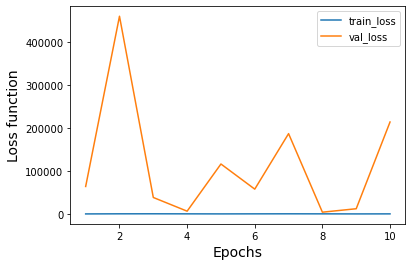

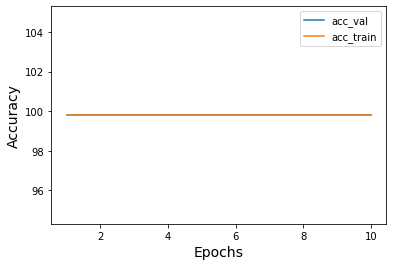

In [255]:
Train_loss, Val_loss,Train_acc,Val_acc=bay_model.Train_metric()
Train_loss=Train_loss.to('cpu')
Val_loss=Val_loss.to('cpu')
Train_acc=Train_acc.to('cpu')
Val_acc=Val_acc.to('cpu')

plt.plot(epoc,Train_loss,label='train_loss')
plt.plot(epoc,Val_loss,label='val_loss')
plt.xlabel('Epochs',size=14)
plt.ylabel('Loss function',size=14)
plt.legend()
plt.show()
plt.plot(epoc,Train_acc,label='acc_val')
plt.plot(epoc,Val_acc,label='acc_train')
plt.xlabel('Epochs',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend()
plt.show()

In [256]:
Train_acc

tensor([99.8000, 99.8000, 99.8000, 99.8000, 99.8000, 99.8000, 99.8000, 99.8000,
        99.8000, 99.8000])

# Classification Report

In [257]:
# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [258]:
print('Classification Report:')
y_test = y_test.to('cpu')

print(classification_report(y_test, y_pred, labels=[1,0], digits=4))       
cm_det = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm_det, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['STABLE', 'UNSTABLE'])
ax.yaxis.set_ticklabels(['STABLE', 'UNSTABLE'])


Classification Report:


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [264]:
y_pred

[[1.0, 0.0],
 [1.0, 2.2848171460816142e-41],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 3.086393390004881e-30],
 [1.0, 8.09924571854026e-10],
 [1.0, 3.472898505477284e-27],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 8.260671756033428e-34],
 [1.0, 0.0],
 [1.0, 9.778777614044554e-12],
 [1.0, 2.1001033309341665e-21],
 [1.0, 0.0],
 [1.0, 1.9342768421823341e-22],
 [1.0, 6.316566533807194e-35],
 [1.0, 1.8216880036222622e-44],
 [1.0, 7.356463323830157e-30],
 [1.0, 0.0],
 [1.0, 3.209128597761631e-33],
 [1.0, 3.603537633838194e-19],
 [1.0, 0.0],
 [1.0, 2.200917457409152e-26],
 [1.0, 1.401298464324817e-45],
 [1.0, 7.581052972882585e-12],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 1.6186505950993723e-26],
 [1.0, 1.347121463097091e-39],
 [1.0, 0.0],
 [0.9999999403953552, 8.408806451143391e-08],
 [1.0, 1.4956782051163327e-17],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 3.786350153247954e-37],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 1.401298464324817e-45],
 [1.0, 0.0],
 [1.0, 1.1649106522208353e-25],
 [0.9000000357627869, 0.10000000149011612],
 

In [240]:
accuracy,y_pred = bay_model.evaluate(x_test, y_test, device=device)

tensor([[1.0000e+00, 3.4720e-24]], device='cuda:0')


In [193]:
accuracy,y_pred = bay_model.evaluate(x_test, y_test, device=device)

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], de

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], de

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], de

tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], de